学习R语言分类，其实是一些机器学习算法。

In [51]:
pkgs <- c("rpart", "rpart.plot", "party", "randomForest", "e1071")
install.packages(pkgs, depend=TRUE)

Warning message:
"packages 'rpart', 'rpart.plot', 'party', 'randomForest' are in use and will not be installed"


package 'e1071' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\86151\AppData\Local\Temp\Rtmpaygbpj\downloaded_packages


# 数据准备

In [52]:
# 下载数据
loc <- "http://archive.ics.uci.edu/ml/machine-learning-databases/" 
ds <- "breast-cancer-wisconsin/breast-cancer-wisconsin.data" 
url <- paste(loc, ds, sep="") 
breast <- read.table(url, sep=",", header=FALSE, na.strings="? ") 
names(breast) <- c("ID", "clumpThickness", "sizeUniformity", "shapeUniformity", 
"maginalAdhesion", "singleEpithelialCellSize", "bareNuclei", "blandChromatin", 
"normalNucleoli", "mitosis", "class")

# 转换数据
df <- breast[, -1]
df$class <- factor(df$class, levels=c(2, 4), labels=c("benign", "malignant"))
df$bareNuclei <- as.numeric(as.character(df$bareNuclei))

# 拆分数据
set.seed(1234)
train <- sample(nrow(df), 0.7*nrow(df))
df.train <- df[train, ]
df.validate <- df[-train, ]
table(df.train$class)
table(df.validate$class)

Warning message:
"NAs introduced by coercion"



   benign malignant 
      319       170 


   benign malignant 
      139        71 

# 逻辑回归

In [53]:
# 拟合逻辑回归
fit.logit <- glm(class~., data=df.train, family=binomial)

# 检查模型
summary(fit.logit)


Call:
glm(formula = class ~ ., family = binomial, data = df.train)

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -12.4412     2.0547  -6.055  1.4e-09 ***
clumpThickness             0.7407     0.2262   3.275  0.00106 ** 
sizeUniformity            -0.0320     0.3399  -0.094  0.92500    
shapeUniformity            0.2073     0.3715   0.558  0.57680    
maginalAdhesion            0.5194     0.1708   3.041  0.00236 ** 
singleEpithelialCellSize  -0.3217     0.2613  -1.231  0.21831    
bareNuclei                 0.5851     0.1881   3.111  0.00187 ** 
blandChromatin             0.8599     0.2923   2.942  0.00326 ** 
normalNucleoli             0.4036     0.1828   2.208  0.02725 *  
mitosis                    0.8923     0.3552   2.512  0.01200 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 621.04  on 477  degrees of freedom
Residual de

In [54]:
# 对训练集进行预测
prob <- predict(fit.logit, df.validate, type="response")

# 转化为分类
logit.pred <- factor(prob>.5, levels=c(FALSE, TRUE), labels=c("benign", "malignant"))

# 评估预测准确性
logit.pref <- table(df.validate$class, logit.pred, dnn=c("Actual", "Predicted"))
logit.pref


           Predicted
Actual      benign malignant
  benign       129         6
  malignant      1        69

In [55]:
logit.fit.reduced <- step(fit.logit)

Start:  AIC=72.39
class ~ clumpThickness + sizeUniformity + shapeUniformity + maginalAdhesion + 
    singleEpithelialCellSize + bareNuclei + blandChromatin + 
    normalNucleoli + mitosis

                           Df Deviance    AIC
- sizeUniformity            1   52.399 70.399
- shapeUniformity           1   52.686 70.686
- singleEpithelialCellSize  1   53.910 71.910
<none>                          52.390 72.390
- normalNucleoli            1   57.465 75.465
- mitosis                   1   57.966 75.966
- blandChromatin            1   62.856 80.856
- maginalAdhesion           1   63.044 81.044
- bareNuclei                1   64.982 82.982
- clumpThickness            1   68.323 86.323

Step:  AIC=70.4
class ~ clumpThickness + shapeUniformity + maginalAdhesion + 
    singleEpithelialCellSize + bareNuclei + blandChromatin + 
    normalNucleoli + mitosis

                           Df Deviance    AIC
- shapeUniformity           1   52.876 68.876
- singleEpithelialCellSize  1   53.918 69.

# 决策树

## 经典决策树

In [56]:
library(rpart)
set.seed(1234)

# 生成树
dtree <- rpart(
    class~.,
    data=df.train,
    method="class",
    parms=list(split="information")
)

dtree$cptable

,CP,nsplit,rel error,xerror,xstd
1,0.81764706,0,1.00000000,1.0000000,0.06194645
2,0.04117647,1,0.18235294,0.1823529,0.03169642
3,0.01764706,3,0.10000000,0.1588235,0.02970979
4,0.01000000,4,0.08235294,0.1235294,0.02637116


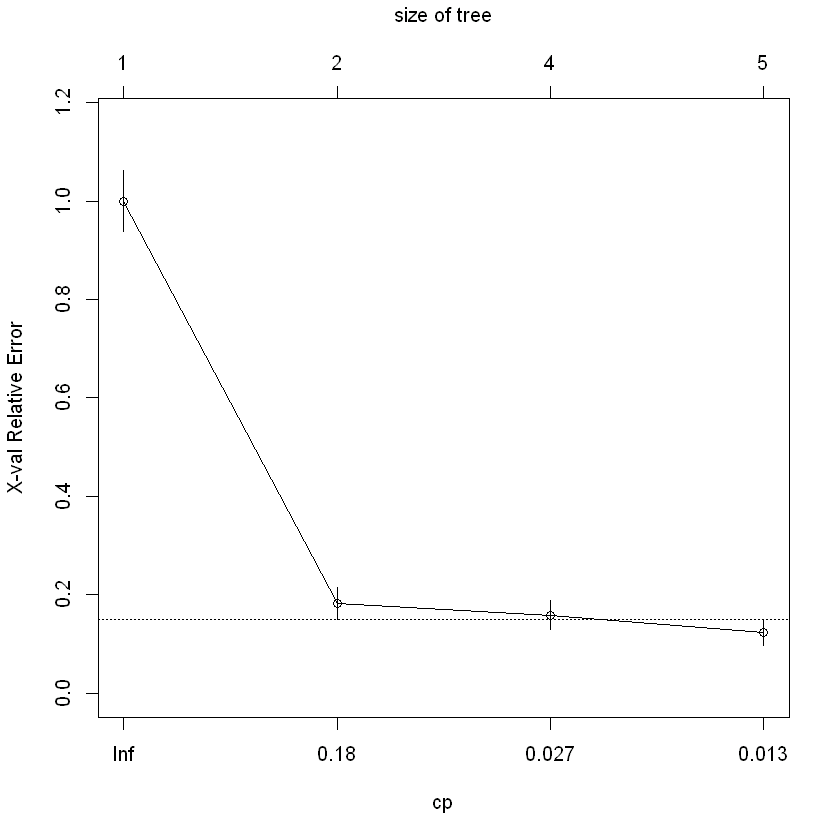

In [57]:
plotcp(dtree)

In [58]:
dtree.pruned <- prune(dtree, cp=0.0176)

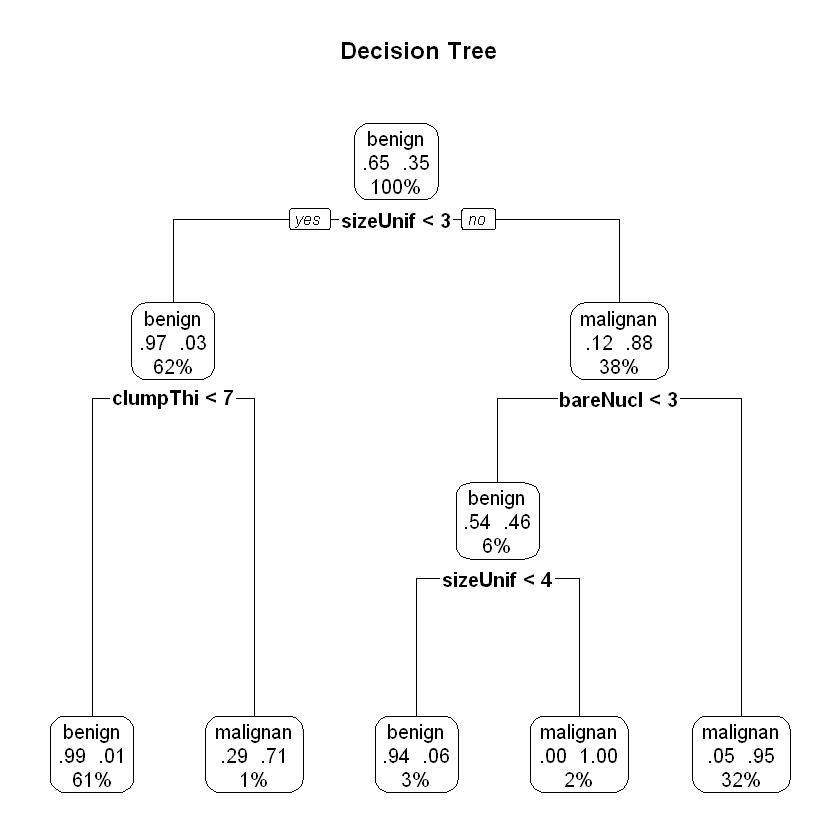

In [59]:
library(rpart.plot)
prp(dtree.pruned, type=2, extra=104, fallen.leaves=TRUE, main="Decision Tree")

In [87]:
dtree.pred <- predict(dtree.pruned, df.validate, type="class")
dtree.perf <- table(df.validate$class, dtree.pred, dnn=c("Actual", "Predicted"))
dtree.perf

           Predicted
Actual      benign malignant
  benign       129        10
  malignant      2        69

## 条件推断树

In [61]:
summary(df.train)

 clumpThickness   sizeUniformity   shapeUniformity  maginalAdhesion 
 Min.   : 1.000   Min.   : 1.000   Min.   : 1.000   Min.   : 1.000  
 1st Qu.: 2.000   1st Qu.: 1.000   1st Qu.: 1.000   1st Qu.: 1.000  
 Median : 4.000   Median : 1.000   Median : 2.000   Median : 1.000  
 Mean   : 4.448   Mean   : 3.106   Mean   : 3.217   Mean   : 2.744  
 3rd Qu.: 6.000   3rd Qu.: 5.000   3rd Qu.: 5.000   3rd Qu.: 3.000  
 Max.   :10.000   Max.   :10.000   Max.   :10.000   Max.   :10.000  
                                                                    
 singleEpithelialCellSize   bareNuclei     blandChromatin   normalNucleoli  
 Min.   : 1.000           Min.   : 1.000   Min.   : 1.000   Min.   : 1.000  
 1st Qu.: 2.000           1st Qu.: 1.000   1st Qu.: 2.000   1st Qu.: 1.000  
 Median : 2.000           Median : 1.000   Median : 3.000   Median : 1.000  
 Mean   : 3.215           Mean   : 3.517   Mean   : 3.395   Mean   : 2.818  
 3rd Qu.: 4.000           3rd Qu.: 5.750   3rd Qu.: 4.000   3rd

In [62]:
nlevels(df.train$class)

[1] 2

In [63]:
str(df.train)

'data.frame':	489 obs. of  10 variables:
 $ clumpThickness          : int  10 10 7 2 1 5 4 1 3 3 ...
 $ sizeUniformity          : int  4 3 1 1 2 1 1 1 2 1 ...
 $ shapeUniformity         : int  6 5 2 1 3 1 2 1 2 1 ...
 $ maginalAdhesion         : int  1 1 3 1 1 1 1 1 1 1 ...
 $ singleEpithelialCellSize: int  2 10 2 2 2 2 2 1 2 2 ...
 $ bareNuclei              : num  10 5 1 1 1 1 1 1 1 3 ...
 $ blandChromatin          : int  5 3 2 1 1 3 3 2 2 3 ...
 $ normalNucleoli          : int  3 10 1 1 1 1 1 1 3 1 ...
 $ mitosis                 : int  1 2 1 1 1 1 1 1 1 1 ...
 $ class                   : Factor w/ 2 levels "benign","malignant": 2 2 1 1 1 1 1 1 1 1 ...


In [64]:
colnames(df.train)

[1] "clumpThickness"           "sizeUniformity"          
 [3] "shapeUniformity"          "maginalAdhesion"         
 [5] "singleEpithelialCellSize" "bareNuclei"              
 [7] "blandChromatin"           "normalNucleoli"          
 [9] "mitosis"                  "class"

In [65]:
sum(is.na(df.train))

[1] 11

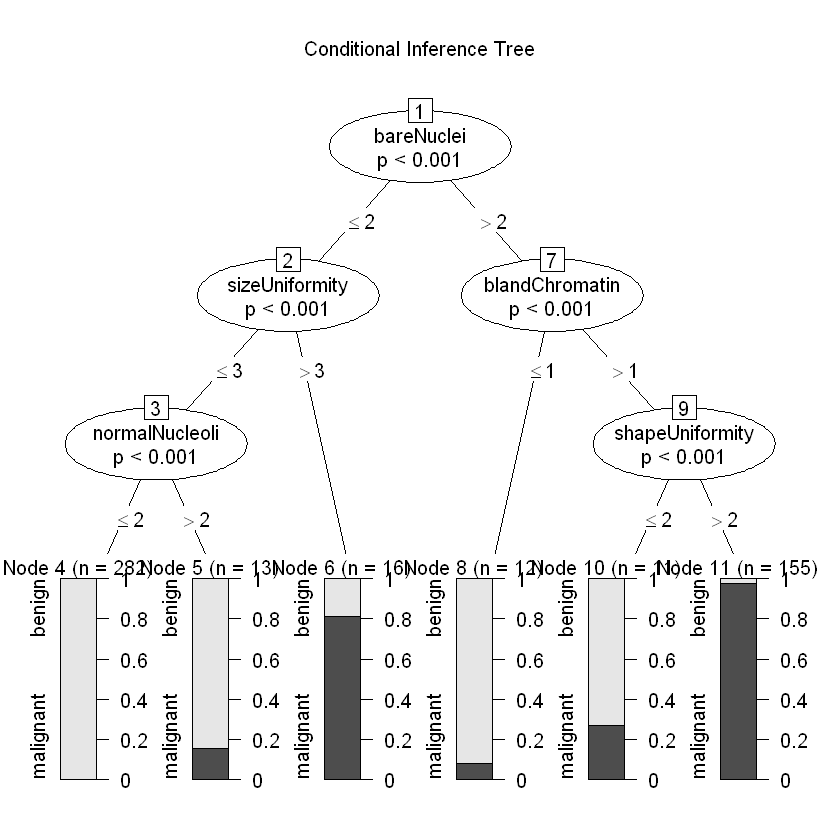

In [66]:
library(party)

fit.ctree <- ctree(
    class~.,
    data=df.train
)

plot(fit.ctree, main="Conditional Inference Tree")

In [69]:
ctree.pred <- predict(fit.ctree, df.validate, type="response")
ctree.perf <- table(df.validate$class, ctree.pred, dnn=c("Actual", "Predicted"))
ctree.perf

           Predicted
Actual      benign malignant
  benign       131         8
  malignant      4        67

# 随机森林

In [67]:
str(df.train)

'data.frame':	489 obs. of  10 variables:
 $ clumpThickness          : int  10 10 7 2 1 5 4 1 3 3 ...
 $ sizeUniformity          : int  4 3 1 1 2 1 1 1 2 1 ...
 $ shapeUniformity         : int  6 5 2 1 3 1 2 1 2 1 ...
 $ maginalAdhesion         : int  1 1 3 1 1 1 1 1 1 1 ...
 $ singleEpithelialCellSize: int  2 10 2 2 2 2 2 1 2 2 ...
 $ bareNuclei              : num  10 5 1 1 1 1 1 1 1 3 ...
 $ blandChromatin          : int  5 3 2 1 1 3 3 2 2 3 ...
 $ normalNucleoli          : int  3 10 1 1 1 1 1 1 3 1 ...
 $ mitosis                 : int  1 2 1 1 1 1 1 1 1 1 ...
 $ class                   : Factor w/ 2 levels "benign","malignant": 2 2 1 1 1 1 1 1 1 1 ...


In [68]:
library(randomForest)
set.seed(1234)

# 生成森林
fit.forest <- randomForest(
    class~.,
    data=df.train,
    na.action=na.roughfix,
    importance=TRUE
)

fit.forest


Call:
 randomForest(formula = class ~ ., data = df.train, importance = TRUE,      na.action = na.roughfix) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 2.66%
Confusion matrix:
          benign malignant class.error
benign       313         6  0.01880878
malignant      7       163  0.04117647

In [71]:
importance(fit.forest, type=2)

,MeanDecreaseGini
clumpThickness,11.382432
sizeUniformity,63.037519
shapeUniformity,49.027649
maginalAdhesion,4.275345
singleEpithelialCellSize,14.504981
bareNuclei,42.736364
blandChromatin,22.484755
normalNucleoli,11.375285
mitosis,1.755382


In [72]:
forest.pred <- predict(fit.forest, df.validate)
forest.perf <- table(df.validate$class, forest.pred, dnn=c("Actual", "Predicted"))
forest.perf

           Predicted
Actual      benign malignant
  benign       128         7
  malignant      2        68

# 支持向量机

In [74]:
library(e1071)
set.seed(1234)

# SVM
fit.svm <- svm(class~., data=df.train)

fit.svm


Call:
svm(formula = class ~ ., data = df.train)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 

Number of Support Vectors:  74


In [76]:
svm.pred <- predict(fit.svm, na.omit(df.validate))
svm.perf <- table(na.omit(df.validate)$class, svm.pred, dnn=c("Actual", "Predicted"))
svm.perf

           Predicted
Actual      benign malignant
  benign       126         9
  malignant      0        70

In [77]:
# 带RBF核的SVM模型
set.seed(1234)
tuned <- tune.svm(
    class~.,
    data=df.train,
    gamma=10^(-6:1),
    cost=10^(-10:10)
)

# 输出最优模型
tuned


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 gamma cost
  0.01    1

- best performance: 0.02740302 


In [78]:
fit.svm <- svm(class~., data=df.train, gamma=0.1, cost=1)
svm.pred  <- predict(fit.svm, na.omit(df.validate))
svm.perf <- table(na.omit(df.validate)$class, svm.pred, dnn=c("Actual", "Predicted"))
svm.perf

           Predicted
Actual      benign malignant
  benign       127         8
  malignant      0        70

# 选择预测效果最好的解

In [79]:
performance <- function(table, n=2){
    if(!all(dim(table) == c(2, 2))){
        stop("The table must be 2x2")
    }

    # 得到频数
    tn <- table[1, 1]
    fp <- table[1, 2]
    fn <- table[2, 1]
    tp <- table[2, 2]
    
    # 计算统计量
    sensitivity <- tp / (tp + fn)
    specificity <- tn / (tn + fp)
    ppp <- tp / (tp + fp)
    npp <- tn / (tn + fn)

    # 输出结果
    result <- paste(
        "Sensitivity:", round(sensitivity, n),
        "\nSpecificity:", round(specificity, n),
        "\nPositive Predictive Value:", round(ppp, n),
        "\nNegative Predictive Value:", round(npp, n)
    )
    cat(result)
}

In [80]:
performance(logit.pref)

Sensitivity: 0.99 
Specificity: 0.96 
Positive Predictive Value: 0.92 
Negative Predictive Value: 0.99

In [88]:
performance(dtree.perf)

Sensitivity: 0.97 
Specificity: 0.93 
Positive Predictive Value: 0.87 
Negative Predictive Value: 0.98

In [89]:
performance(ctree.perf)

Sensitivity: 0.94 
Specificity: 0.94 
Positive Predictive Value: 0.89 
Negative Predictive Value: 0.97

In [90]:
performance(forest.perf)

Sensitivity: 0.97 
Specificity: 0.95 
Positive Predictive Value: 0.91 
Negative Predictive Value: 0.98

In [91]:
performance(svm.perf)

Sensitivity: 1 
Specificity: 0.94 
Positive Predictive Value: 0.9 
Negative Predictive Value: 1

# 用rattle包进行数据挖掘

In [92]:
install.packages("rattle")

package 'rattle' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\86151\AppData\Local\Temp\Rtmpaygbpj\downloaded_packages


In [95]:
install.packages("RGtk2")

Warning message:
"package 'RGtk2' is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages"


In [96]:
library(rattle)
rattle()

ERROR: Error in rattle(): 
The RGtk2 package is not available but is required. 
Please install the package using, for example: 

  install.packages("RGtk2")


